In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D , Flatten,GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard,ReduceLROnPlateau
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

import pandas as pd

In [2]:
train_loc = './COVIDwavSplitTrimmedMFCC/train/'
test_loc = './COVIDwavSplitTrimmedMFCC/val/'

In [6]:
trdata = ImageDataGenerator(rescale=1.0 / 255)
traindata = trdata.flow_from_directory(directory=train_loc, target_size=(224,224))
tsdata = ImageDataGenerator(rescale=1.0 / 255)
testdata = tsdata.flow_from_directory(directory=test_loc, target_size=(224,224))

Found 4392 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [7]:
base_model = ResNet50(weights=None,include_top=False,input_shape= (224,224,3))

In [8]:
x  = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(2, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)
adam = Adam(lr=0.0000001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()
checkpoint = ModelCheckpoint("covid_res.h5", monitor='val_accuracy', verbose=1, 
                             save_best_only=True, save_weights_only=False, mode='auto')
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
counter = Counter(traindata.classes)                       
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
hist = model.fit(traindata, steps_per_epoch=traindata.samples//traindata.batch_size, validation_data=testdata, 
                 validation_steps=testdata.samples//testdata.batch_size, 
                 epochs=100,callbacks=[checkpoint,early])

Epoch 1/100
137/137 [==============================] - ETA: 0s - loss: 1.8519 - accuracy: 0.4892
Epoch 00001: val_accuracy improved from -inf to 0.48926, saving model to covid_res.h5
137/137 [==============================] - 33s 239ms/step - loss: 1.8519 - accuracy: 0.4892 - val_loss: 0.8294 - val_accuracy: 0.4893
Epoch 2/100
137/137 [==============================] - ETA: 0s - loss: 1.8150 - accuracy: 0.4833
Epoch 00002: val_accuracy did not improve from 0.48926
137/137 [==============================] - 31s 225ms/step - loss: 1.8150 - accuracy: 0.4833 - val_loss: 1.0843 - val_accuracy: 0.4883
Epoch 3/100
137/137 [==============================] - ETA: 0s - loss: 1.7765 - accuracy: 0.5025
Epoch 00003: val_accuracy did not improve from 0.48926
137/137 [==============================] - 31s 223ms/step - loss: 1.7765 - accuracy: 0.5025 - val_loss: 1.0999 - val_accuracy: 0.4873
Epoch 4/100
137/137 [==============================] - ETA: 0s - loss: 1.7869 - accuracy: 0.4856
Epoch 00004: v

137/137 [==============================] - ETA: 0s - loss: 1.4683 - accuracy: 0.5080
Epoch 00028: val_accuracy did not improve from 0.49316
137/137 [==============================] - 31s 223ms/step - loss: 1.4683 - accuracy: 0.5080 - val_loss: 0.8313 - val_accuracy: 0.4922
Epoch 29/100
137/137 [==============================] - ETA: 0s - loss: 1.4926 - accuracy: 0.5018
Epoch 00029: val_accuracy did not improve from 0.49316
137/137 [==============================] - 30s 222ms/step - loss: 1.4926 - accuracy: 0.5018 - val_loss: 0.8192 - val_accuracy: 0.4873
Epoch 30/100
137/137 [==============================] - ETA: 0s - loss: 1.4600 - accuracy: 0.4899
Epoch 00030: val_accuracy did not improve from 0.49316
137/137 [==============================] - 30s 221ms/step - loss: 1.4600 - accuracy: 0.4899 - val_loss: 0.8102 - val_accuracy: 0.4844
Epoch 31/100
137/137 [==============================] - ETA: 0s - loss: 1.4629 - accuracy: 0.4966
Epoch 00031: val_accuracy did not improve from 0.49316

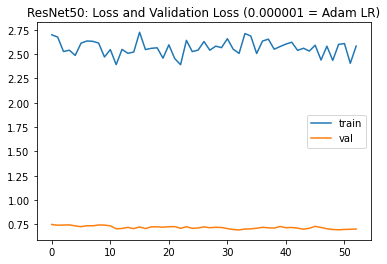

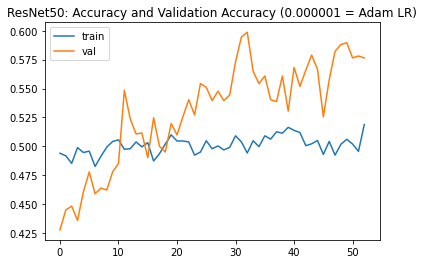

In [12]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title('ResNet50: Loss and Validation Loss (0.000001 = Adam LR)')
plt.legend();
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title('ResNet50: Accuracy and Validation Accuracy (0.000001 = Adam LR)')
plt.legend();
plt.show()


In [13]:
import numpy as np
Y_pred = model.predict(testdata)
y_pred = np.argmax(Y_pred, axis = 1)

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [19]:
cm = confusion_matrix(testdata.classes,y_pred)

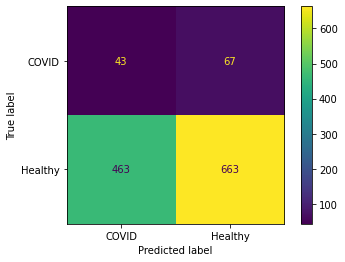

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['COVID','Healthy'])
disp.plot()